In [84]:
import pandas as pd
import numpy as np
import requests
import json
import time

from prophet import Prophet
from functions import forecast_pib
from keys import token_inegi, token_banxico

In [79]:
####################################################################
#### Query and forecast GDP total values using previously defined
#### function. Values are afterwards going  to be used to forecast 
#### industrial GDP.
####################################################################

print('0.00 - Calculating GDP forecasts')
print('-----')
pib= forecast_pib()

00 - Checking last INEGI records
...


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


... Last YQ has not changed. Forecasting with last registered values
01 - forecasting INEGI records...
02 - Getting BANXICOs latest macro expectations survey data
03 - Adjusting naive forecasts to BANXICOs data
04 - Forecasts complete!


In [22]:
####################################################################
#### This file is used to check which is the last recorded quarter 
#### from previous forecasts. If a new record is observed, then the
#### file is updated and everything gets re-forecasted.
####################################################################

print('-----')
print('1.00 - Checking las INEGI records')

#Import INEGI Last Values file
lv= pd.read_csv('INEGI_LastValues.csv')

#Last records
last_year_record= int(lv[(lv['Var'] == 'PIB_Industrial') & (lv['timestamp'] == lv.loc[lv['Var'] == 'PIB_Industrial', 'timestamp'].max())]['Y'])
last_quarter_record= int(lv[(lv['Var'] == 'PIB_Industrial') & (lv['timestamp'] == lv.loc[lv['Var'] == 'PIB_Industrial', 'timestamp'].max())]['Q'])

In [81]:
####################################################################
#### Query INEGI's API to get latest macroeconomic data for GDP, 
#### industrial GDP and Investment. If new data is identified,
#### leave a new record in INEGI_LastValues.csv
####################################################################

print('2.00 - Querying INEGI for new Industrial GDP data')

#Query
query= f'https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/6207062155/es/0700/false/BISE/2.0/{token_inegi}?type=json'
response= requests.get(query)

#Transform JSON to dataframe
dat= pd.json_normalize(response.json()['Series'][0]['OBSERVATIONS']).rename(columns= {'OBS_VALUE': 'pib_industrial_var_anual'})

dat['y']= pd.to_numeric([dat['TIME_PERIOD'][i].split('/')[0] for i in range(0, len(dat))])
dat['q']= pd.to_numeric([dat['TIME_PERIOD'][i].split('/')[1] for i in range(0, len(dat))])
dat['pib_industrial_var_anual']= pd.to_numeric(dat['pib_industrial_var_anual'])
dat['yq']= [str(dat['y'][i])+'Q'+str(dat['q'][i]) for i in range(0, len(dat))]

########################
#Check that last observation is the one registered 
#If new observations are published, then update INEGI_lastValues.py file

y_check= dat.iloc[-1, -3] == last_year_record #Year check
q_check= dat.iloc[-1, -2] == last_quarter_record #Quarter check

#Validation and updates
if (y_check == True) & (q_check == True):
    print('----')
    print('Last YQ has not changed. Forecasting with last registered values')
    
    pib_lastValue = [dat.iloc[-1, -3], dat.iloc[-1, -2]]

elif (y_check == True) & (q_check == False):
    print('----')
    print('Year is same, but new Q data published. Forecasting with new quarter data')
    print('Updating INEGI_LastValues.csv file')
    
    lv= lv.append({'Var': 'PIB', 
                   'Y': dat.iloc[-1, -3], 
                   'Q': dat.iloc[-1, -2], 
                   'timestamp': time.time()}, ignore_index= True)
    lv.to_csv('INEGI_LastValues.csv', index= False)
        
    pib_lastValue = [dat.iloc[-1, -3], dat.iloc[-1, -2]]
        
elif (y_check == False):
    print('----')
    print('New year, new data published. Forecasting with new quarter data')
    print('Updating INEGI_LastValues.csv file')
    
    lv= lv.append({'Var': 'PIB', 
                   'Y': dat.iloc[-1, -3], 
                   'Q': dat.iloc[-1, -2], 
                   'timestamp': time.time()}, ignore_index= True)
    lv.to_csv('INEGI_LastValues.csv', index= False)
        
    pib_lastValue = [dat.iloc[-1, -3], dat.iloc[-1, -2]]

########################
##Filter selected columns
print('----')
print('3.00 - Calculating dependent variable')

dat= dat[['yq', 'pib_industrial_var_anual']]

#Can only obtain % yoy variation values from INEGI's API, so here are base absolute values
base_1993= [1689645.0, 1665390.7, 1653018.0, 1715589.1]

#Calculate remaining absolute values
dat['pib_industrial_abs'] = np.nan
dat.iloc[0:4, -1] = base_1993
for i in range(4, len(dat)):
    dat.iloc[i, -1] = dat.iloc[i-4, -1] * (1+ dat.iloc[i, -2] / 100)

#Attaching PIB total absolute values (query from previous function)
index= pib.loc[(pib['year'] == pib_lastValue[0]) & (pib['quarter'] == pib_lastValue[1]), ].index[0]
dat['pib'] = pib.iloc[:index+1,-1]

#calculate Dependent variable (pct share of industrial gdp)
dat['pct_pib_secondary_industrial'] = dat['pib_industrial_abs'] / dat['pib']
dat= dat[['yq', 'pct_pib_secondary_industrial']]

2.00 - Querying INEGI for new Industrial GDP data
----
Year is same, but new Q data published. Forecasting with new quarter data
Updating INEGI_LastValues.csv file
----
3.00 - Calculating dependent variable


In [109]:
####################################################################
#### Facebook Prophet model to forecast automatically GDP growth
#### based on new historic recors , towards 2032
####################################################################

#Prepare data
ts= dat[['yq', 'pct_pib_secondary_industrial']][66:].rename(columns= {'yq': 'ds',  'pct_pib_secondary_industrial': 'y'})
ts['ds'] = pd.PeriodIndex(ts['ds'], freq='Q').to_timestamp()
ts['cap'] = 0.165
ts['floor'] = 0.155

#Fit Model
m= Prophet(growth = 'logistic')
m.fit(ts)

#Forecast period
#Remaining quarters of the year to be forecasted
if pib_lastValue[1] == 1:
    remaining_qs = [str(pib_lastValue[0])+i for i in ['Q2', 'Q3', 'Q4']]
elif pib_lastValue[1] == 2:
    remaining_qs = [str(pib_lastValue[0])+i for i in ['Q3', 'Q4']]
elif pib_lastValue[1] == 3:
    remaining_qs = [str(pib_lastValue[0])+i for i in ['Q4']]
else:
    remaining_qs = []

#Next years to be forecasted
future_ds= np.append(remaining_qs, 
                     [str(y)+q for y in range(pib_lastValue[0] + 1, 2033) for q in ['Q1', 'Q2', 'Q3', 'Q4']])

#Forecast to 2023
future= pd.DataFrame(columns=['ds'])
future['ds']= pd.PeriodIndex(future_ds, freq='Q').to_timestamp()
future['cap'] = 0.168
future['floor'] = 0.155
forecast = m.predict(future)

#Integrate historic w/ forecast dataframes
fnl= pd.DataFrame(columns= ['ds', 'y', 'yhat'])
fnl['ds'] = pd.PeriodIndex(ts['ds'], freq='Q')
fnl['y'] = ts['y'].reset_index(drop=True)

forecast['y'] = np.nan
forecast['ds'] = pd.PeriodIndex(forecast['ds'], freq='Q')
f= forecast[['ds', 'y', 'yhat']]

fnl= pd.concat([fnl, f]).reset_index(drop= True)
fnl['year'] = pd.PeriodIndex(fnl['ds'], freq='Q').year
fnl['quarter'] = pd.PeriodIndex(fnl['ds'], freq='Q').quarter

index_cut= fnl[(fnl['year'] == pib_lastValue[0]) & (fnl['quarter'] == pib_lastValue[1])].index[0]
fnl['full'] = np.append(fnl.iloc[:index_cut+1, 1], 
                        fnl.iloc[index_cut+1:, 2])

## Ajustes en predicciones de Q2s por debajo de la media historica de Q2
q2 = fnl[(fnl['y'].notna()) & (fnl['year'] > 2009)].groupby('quarter')['y'].mean()[2]
fnl.loc[(fnl['y'].isna()) & (fnl['quarter'] == 2) & (fnl['yhat'] < q2), 'yhat'] = q2

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<AxesSubplot:>

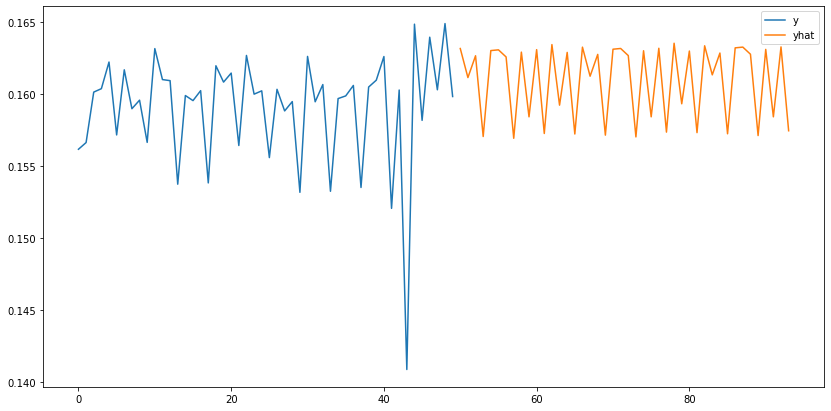

In [110]:
fnl[['y', 'yhat']].plot(figsize= (14,7))

In [113]:
fnl[['year', 'quarter', 'full']]

,year,quarter,full
0,2009,3,0.156161
1,2009,4,0.156627
2,2010,1,0.160132
3,2010,2,0.160368
4,2010,3,0.162219
...,...,...,...
89,2031,4,0.157113
90,2032,1,0.163097
91,2032,2,0.157322
92,2032,3,0.163269
